## Benchmarks for the pyodide 0.17.0 release


In [7]:
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

In [11]:
DATA = Path("./data/")

In [12]:
def load_benchmark(data_dir: Path, name : str) -> pd.DataFrame:

    df_raw = pd.read_json(DATA/ f"benchmarks-{name}.json").T
    df = pd.DataFrame({key: df_raw[key] / df_raw['native'] for key in ['firefox', 'chrome']})
    # smoothing results are equal to 0 for some reason
    df = df[(~df.isna().any(axis=1)) & ~df.index.isin(['smoothing'])]
    df = df.unstack(-1).to_frame(name)
    return df

In [52]:
out = []

for tok in ['fastcomp', 'upstream']:
    for idx in range(1, 4):
        out.append(load_benchmark(DATA, f"{tok}-{idx}").stack(-1).to_frame('rate'))

df_v = pd.concat(out, axis=0).reset_index()
df_v.columns = ['browser', 'name', 'run_id', 'ratio']
df_v['version'] = df_v['run_id'].str.slice(0, -2)

df_v = df_v[df_v['browser'] == 'firefox']

# subsample benchmarks to make the figure more readable
col_names = df_v['name'].drop_duplicates().sample(19, random_state=2).values

mask = df_v['name'].isin(col_names)
df_v = df_v[mask].copy()

# Store column names in ascending order
col_names = df_v[df_v['version']=='fastcomp'].groupby('name')['ratio'].mean().sort_values(ascending=False).index.tolist()

df_v['version'] = (df_v['version']
                   .str.replace('fastcomp', 'emscripten 1.38.44 with fastcomp backend')
                   .str.replace('upstream', 'emscripten 2.0.12 with upstream LLVM backend'))

In [48]:
df_v.shape[0] // 4

33

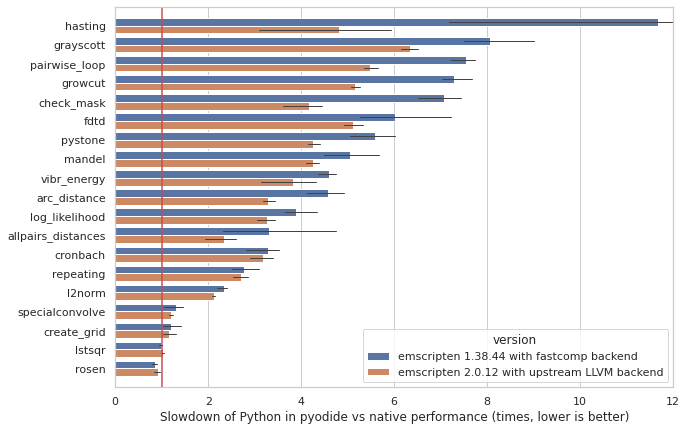

In [53]:
import seaborn as sns

sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(figsize=(10, 7))


sns.barplot(x='ratio', y='name', hue='version', data=df_v, ax=ax, order=col_names, errwidth=1)
ax.set_xlim(0, 12)
ax.set_xlabel('Slowdown of Python in pyodide vs native performance (times, lower is better)')
ax.vlines(1, -1, df_v.shape[0] // 6, color='r')
ax.set_ylim(df_v.shape[0] // 6, -1)
_ = ax.set_ylabel("")